In [1]:
import pandas as pd
import gmaps as gp
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
properati = pd.read_csv('datos/properati.csv')
len(properati)

121220

In [3]:
properati.columns

Index([u'id', u'created_on', u'operation', u'property_type', u'place_name',
       u'place_with_parent_names', u'country_name', u'state_name',
       u'geonames_id', u'lat-lon', u'lat', u'lon', u'price', u'currency',
       u'price_aprox_local_currency', u'price_aprox_usd',
       u'surface_total_in_m2', u'surface_covered_in_m2', u'price_usd_per_m2',
       u'price_per_m2', u'floor', u'rooms', u'expenses', u'properati_url',
       u'description', u'title', u'image_thumbnail'],
      dtype='object')

In [4]:
#Saco algunas columnas que no parecen servir
filtrado = properati.drop( ['id','operation','title','description','image_thumbnail','properati_url','property_type',
                            'country_name','state_name','place_name','lat-lon','geonames_id'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
filtrado.dropna(how='all',inplace=True)
filtrado.head(10)

,created_on,place_with_parent_names,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
0,2017-02-01,|Argentina|Capital Federal|Mataderos|,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.00,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN
1,2017-02-01,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,-34.903883,-57.964330,150000.0,USD,2646675.00,150000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-02-01,|Argentina|Capital Federal|Mataderos|,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.00,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN
3,2017-02-01,|Argentina|Capital Federal|Liniers|,-34.647797,-58.516424,95000.0,USD,1676227.50,95000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-01,|Argentina|Buenos Aires Costa Atlántica|Mar de...,-38.002626,-57.549447,64000.0,USD,1129248.00,64000.00,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN
5,2017-02-01,|Argentina|Entre Ríos|Gualeguaychú|,-33.014071,-58.519828,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2017-02-01,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,-34.532957,-58.521782,130000.0,USD,2293785.00,130000.00,106.0,78.0,1226.415094,1666.666667,NaN,NaN,NaN
7,2017-02-01,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.00,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN
8,2017-02-01,|Argentina|Capital Federal|Belgrano|,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.00,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN
9,2017-02-01,|Argentina|Santa Fe|Rosario|,-32.942031,-60.725919,460000.0,ARS,455201.45,25798.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#separo place_with_parent_names, tarda bastante
separado = filtrado['place_with_parent_names'].apply(lambda x: pd.Series(x.split('|')))
# estaria bueno que las columnas tengan el nombre que corresponde y la 0 no tenga nombre
separado.columns = ['a','pais', 'region','localidad','ciudad','barrio','aborrar'] #mejorar
separado = separado.drop(['a','pais','aborrar'],1) # mejorar
separado.head(10)

,region,localidad,ciudad,barrio
0,Capital Federal,Mataderos,,NaN
1,Bs.As. G.B.A. Zona Sur,La Plata,,NaN
2,Capital Federal,Mataderos,,NaN
3,Capital Federal,Liniers,,NaN
4,Buenos Aires Costa Atlántica,Mar del Plata,Centro,
5,Entre Ríos,Gualeguaychú,,NaN
6,Bs.As. G.B.A. Zona Norte,Vicente López,Munro,
7,Capital Federal,Belgrano,,NaN
8,Capital Federal,Belgrano,,NaN
9,Santa Fe,Rosario,,NaN


In [6]:
#Uno las columnas nuevas en el set filtrado
filtrado = pd.concat([filtrado, separado], axis=1)
filtrado.drop('place_with_parent_names',1,inplace=True)

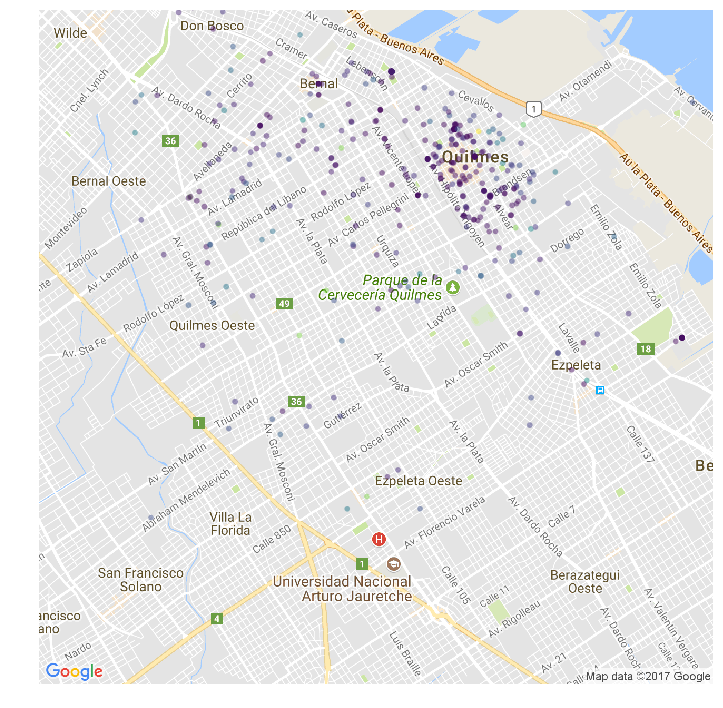

In [7]:
#solo para probar si funcionaba
cap=filtrado.loc[(filtrado['localidad'] == 'Quilmes')] 
gp.scatter(cap['lat'], cap['lon'],cap['surface_total_in_m2'])

In [8]:
filtrado = filtrado.dropna(subset=['price'])  

In [9]:
ranking_precios_usd = filtrado.groupby('region').mean()['price_usd_per_m2'].sort_values(ascending=False)

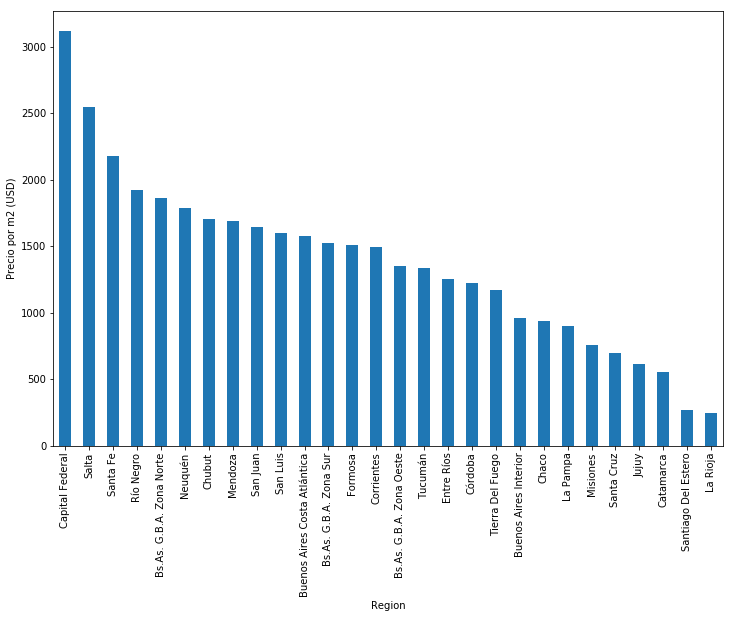

In [10]:
import matplotlib.pyplot as plt
ranking_precios_usd.plot(kind='bar',figsize=(12,8))
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

#### salta en segundo lugar. Investigo por que

In [11]:
salta = filtrado.loc[filtrado['region'] == 'Salta'].sort_values('price_usd_per_m2',ascending = False)
salta

,created_on,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
25343,2017-04-28,-24.791039,-65.411225,2850000.0,USD,50286825.00,2850000.00,120.0,120.0,23750.000000,23750.000000,NaN,4.0,NaN,Salta,Salta,,NaN
26737,2017-04-28,-24.782439,-65.445556,2800000.0,USD,49404600.00,2800000.00,150.0,160.0,18666.666667,17500.000000,NaN,5.0,NaN,Salta,Salta,,NaN
25561,2017-04-28,-24.834989,-65.429807,1100000.0,USD,19408950.00,1100000.00,65.0,65.0,16923.076923,16923.076923,NaN,4.0,NaN,Salta,Salta,,NaN
26738,2017-04-28,-24.780039,-65.445389,2600000.0,USD,45875700.00,2600000.00,155.0,130.0,16774.193548,20000.000000,NaN,5.0,NaN,Salta,Salta,,NaN
25163,2017-04-28,-24.794442,-65.415589,2800000.0,USD,49404600.00,2800000.00,170.0,120.0,16470.588235,23333.333333,NaN,5.0,NaN,Salta,Salta,,NaN
26619,2017-04-28,-24.842185,-65.436251,2500000.0,USD,44111250.00,2500000.00,250.0,170.0,10000.000000,14705.882353,NaN,5.0,NaN,Salta,Salta,,NaN
99227,2017-07-19,NaN,NaN,1200000.0,USD,21173400.00,1200000.00,500.0,500.0,2400.000000,2400.000000,NaN,NaN,NaN,Salta,La Caldera,,NaN
78043,2017-07-19,NaN,NaN,250000.0,USD,4411125.00,250000.00,114.0,NaN,2192.982456,NaN,NaN,NaN,4100.0,Salta,,NaN,NaN
78143,2017-07-19,NaN,NaN,1500000.0,ARS,1484352.56,84125.51,44.0,44.0,1911.943409,34090.909091,NaN,NaN,NaN,Salta,,NaN,NaN
18497,2017-04-06,-24.789827,-65.428404,1686088.0,ARS,1668499.38,94562.01,51.0,51.0,1854.157059,33060.549020,NaN,NaN,NaN,Salta,Salta,,NaN


#### Las 6 primeras filas tienen precios altos en comparacion, tienen bien el precio?
La primer y la tercer fila tiene el mismo precio por m2 en pesos que en usd

La cuarta, quinta y la sexta tiene el precio en pesos mas alto que en dolares

Hay que filtrar todos esos casos

#### Filtro las propiedades cuyos precios tengan incoherencias

In [12]:
filtrado

,created_on,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
0,2017-02-01,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.00,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,Capital Federal,Mataderos,,NaN
1,2017-02-01,-34.903883,-57.964330,150000.0,USD,2646675.00,150000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bs.As. G.B.A. Zona Sur,La Plata,,NaN
2,2017-02-01,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.00,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,Capital Federal,Mataderos,,NaN
3,2017-02-01,-34.647797,-58.516424,95000.0,USD,1676227.50,95000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Capital Federal,Liniers,,NaN
4,2017-02-01,-38.002626,-57.549447,64000.0,USD,1129248.00,64000.00,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN,Buenos Aires Costa Atlántica,Mar del Plata,Centro,
6,2017-02-01,-34.532957,-58.521782,130000.0,USD,2293785.00,130000.00,106.0,78.0,1226.415094,1666.666667,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,Vicente López,Munro,
7,2017-02-01,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.00,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN,Capital Federal,Belgrano,,NaN
8,2017-02-01,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.00,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN,Capital Federal,Belgrano,,NaN
9,2017-02-01,-32.942031,-60.725919,460000.0,ARS,455201.45,25798.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Santa Fe,Rosario,,NaN
10,2017-02-01,-31.420083,-64.188776,70000.0,USD,1235115.00,70000.00,1514.0,NaN,46.235139,NaN,NaN,NaN,NaN,Córdoba,Córdoba,,NaN


In [13]:
filtrado2 = filtrado.loc[(filtrado['price_per_m2'] > filtrado['price_usd_per_m2'])] #Esta borrando los NaN, no es la idea, pueden llegar a servir
filtrado2

,created_on,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,region,localidad,ciudad,barrio
0,2017-02-01,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.00,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,Capital Federal,Mataderos,,NaN
6,2017-02-01,-34.532957,-58.521782,130000.0,USD,2293785.00,130000.00,106.0,78.0,1226.415094,1666.666667,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,Vicente López,Munro,
7,2017-02-01,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.00,45.0,40.0,3066.666667,3450.000000,NaN,NaN,NaN,Capital Federal,Belgrano,,NaN
8,2017-02-01,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.00,65.0,60.0,3000.000000,3250.000000,NaN,NaN,NaN,Capital Federal,Belgrano,,NaN
12,2017-02-01,-34.486019,-58.503814,115000.0,USD,2029117.50,115000.00,39.0,36.0,2948.717949,3194.444444,NaN,NaN,NaN,Bs.As. G.B.A. Zona Norte,San Isidro,Martínez,
13,2017-02-01,NaN,NaN,111700.0,USD,1970890.65,111700.00,50.0,30.0,2234.000000,3723.333333,NaN,1.0,NaN,Capital Federal,Palermo,Palermo Soho,
14,2017-02-01,NaN,NaN,147900.0,USD,2609621.55,147900.00,42.0,31.0,3521.428571,4770.967742,NaN,1.0,NaN,Capital Federal,Palermo,Palermo Soho,
16,2017-02-01,-34.652356,-58.501624,239000.0,USD,4217035.50,239000.00,140.0,98.0,1707.142857,2438.775510,NaN,4.0,NaN,Capital Federal,Mataderos,,NaN
17,2017-02-01,-34.408717,-58.634389,315000.0,USD,5558017.50,315000.00,176.0,78.0,1789.772727,4038.461538,NaN,3.0,NaN,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,Barrio El Golf
19,2017-02-01,-34.580504,-58.405874,350000.0,USD,6175575.00,350000.00,104.0,96.0,3365.384615,3645.833333,NaN,3.0,NaN,Capital Federal,Palermo,,NaN


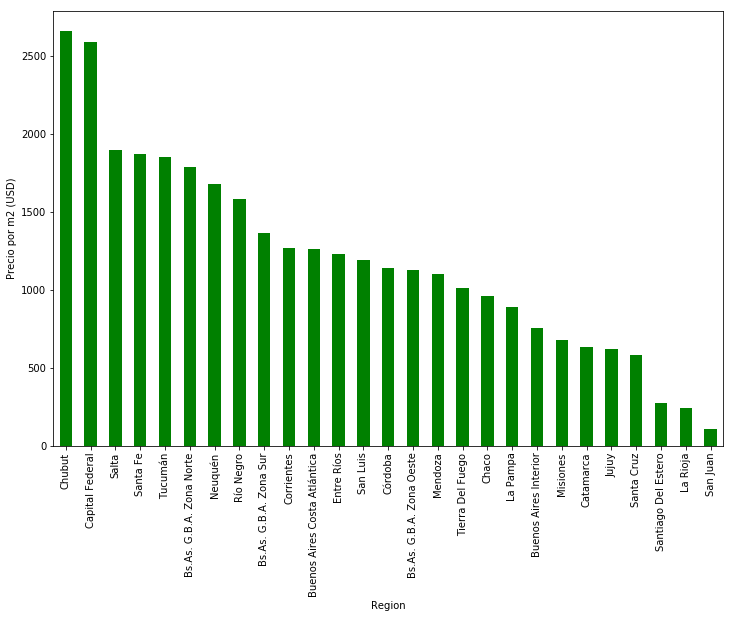

In [14]:
ranking_precios_usd = filtrado2.groupby('region').mean()['price_usd_per_m2'].sort_values(ascending=False)
ranking_precios_usd.plot(kind='bar',figsize=(12,8),color='g')
plt.xlabel('Region')
plt.ylabel('Precio por m2 (USD)')
plt.show()

#### Tiene coherencia?

#### Otra demostracion de los datos erroneos en los precios. Deberia ser parecido al grafico en USD

In [15]:
ranking_precios_usd = filtrado2.groupby('region').mean()['price_usd_per_m2']
ranking_precios_ars = filtrado2.groupby('region').mean()['price_per_m2']

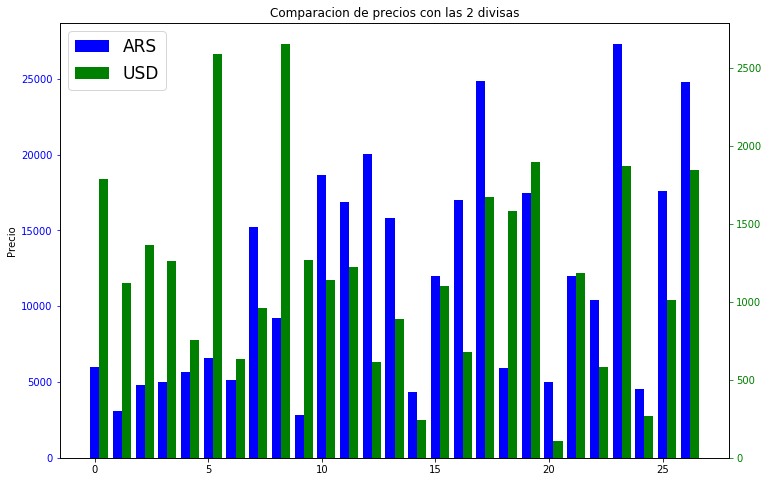

In [17]:
N = filtrado2.region.drop_duplicates().count()

ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig, ax1 = plt.subplots(figsize=(12,8))
ars= ax1.bar(ind, ranking_precios_ars, width, color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
usd = ax2.bar(ind + width, ranking_precios_usd, width, color='g')
ax2.tick_params('y', colors='g')

# add some text for labels, title and axes ticks
ax1.set_ylabel('Precio')
ax1.set_title('Comparacion de precios con las 2 divisas')
#ax.set_xticks(ind + width / 2)
#ax1.set_xticklabels(filtrado2.region.drop_duplicates().values) #funcionaria si no fuera por los acentos

ax1.legend((ars, usd), ('ARS', 'USD'),fontsize = 17)
plt.show()